In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import numpy as np
import os

In [7]:
df = pd.read_csv('data/origindata.csv')
df.info()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 429435 entries, 0 to 429434
Data columns (total 67 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   iso_code                                    429435 non-null  object 
 1   continent                                   402910 non-null  object 
 2   location                                    429435 non-null  object 
 3   date                                        429435 non-null  object 
 4   total_cases                                 411804 non-null  float64
 5   new_cases                                   410159 non-null  float64
 6   new_cases_smoothed                          408929 non-null  float64
 7   total_deaths                                411804 non-null  float64
 8   new_deaths                                  410608 non-null  float64
 9   new_deaths_smoothed                         409378 non-null  float64
 

iso_code                                        0
continent                                   26525
location                                        0
date                                            0
total_cases                                 17631
                                            ...  
population                                      0
excess_mortality_cumulative_absolute       416024
excess_mortality_cumulative                416024
excess_mortality                           416024
excess_mortality_cumulative_per_million    416024
Length: 67, dtype: int64

In [5]:
df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 429435 entries, 0 to 429434
Data columns (total 67 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   iso_code                                    429435 non-null  object 
 1   continent                                   402910 non-null  object 
 2   location                                    429435 non-null  object 
 3   date                                        429435 non-null  object 
 4   total_cases                                 411804 non-null  float64
 5   new_cases                                   410159 non-null  float64
 6   new_cases_smoothed                          408929 non-null  float64
 7   total_deaths                                411804 non-null  float64
 8   new_deaths                                  410608 non-null  float64
 9   new_deaths_smoothed                         409378 non-null  float64
 

In [6]:
df['date'] = pd.to_datetime(df['date'])

dtype('<M8[ns]')

C:\Users\xuant\AppData\Local\Temp\ipykernel_16588\3451056259.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')  # forward-fill dữ liệu bị thiếu


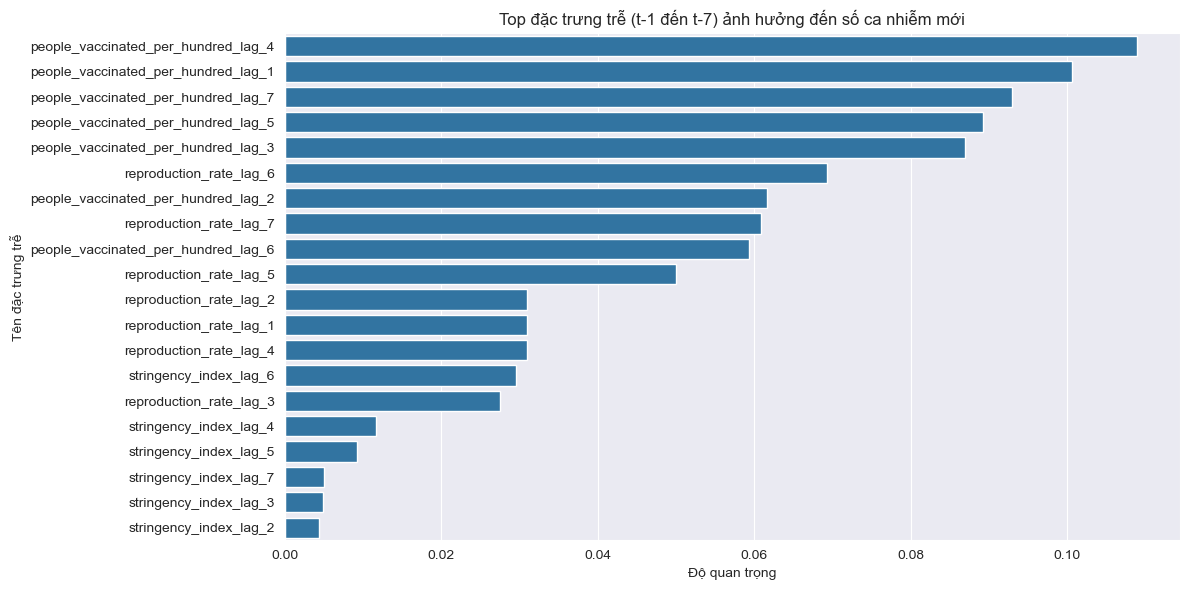

In [4]:
df['date'] = pd.to_datetime(df['date'])

# --- Lọc dữ liệu hợp lệ ---
df = df.sort_values(['location', 'date'])  # rất quan trọng với chuỗi thời gian
df = df.fillna(method='ffill')  # forward-fill dữ liệu bị thiếu
df = df.dropna(subset=['new_cases'])

# --- Chọn các cột đầu vào có ý nghĩa để tạo lag ---
lag_features = [
    'new_tests',
    'total_tests',
    'people_vaccinated_per_hundred',
    'stringency_index',
    'positive_rate',
    'reproduction_rate'
]

# --- Tạo các cột lag từ t-1 đến t-7 cho mỗi trường ---
for feature in lag_features:
    for lag in range(1, 8):
        df[f'{feature}_lag_{lag}'] = df.groupby('location')[feature].shift(lag)

# --- Loại bỏ các dòng chưa đủ dữ liệu (NaN sau khi shift) ---
df_model = df.dropna(subset=[f'{f}_lag_{l}' for f in lag_features for l in range(1, 8)])

# --- Biến đầu ra là new_cases hôm nay ---
X = df_model[[f'{f}_lag_{l}' for f in lag_features for l in range(1, 8)]]
y = df_model['new_cases']

# --- Chia train/test ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Huấn luyện Random Forest ---
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# --- Đánh giá độ quan trọng ---
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X.columns

# --- Vẽ biểu đồ top 20 đặc trưng quan trọng nhất ---
plt.figure(figsize=(12, 6))
sns.barplot(x=importances[indices][:20], y=feature_names[indices][:20])
plt.title('Top đặc trưng trễ (t-1 đến t-7) ảnh hưởng đến số ca nhiễm mới')
plt.xlabel('Độ quan trọng')
plt.ylabel('Tên đặc trưng trễ')
plt.tight_layout()

# --- Lưu ảnh ---
output_dir = 'graphic'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
plt.show()